In [ ]:
# ! pip install fastBPE sacremoses

In [1]:
import torch
import os
import matplotlib.pyplot as plt

def load_lm(lang):
    assert lang in ["en", "de", "ru"]
    # Load an lang LM trained on WMT'19 News Crawl data
    return torch.hub.load('pytorch/fairseq', 'transformer_lm.wmt19.'+lang, tokenizer='moses', bpe='fastbpe')

def eval_lm(lm, lang, filepath, src_lang, n_samples):

    assert lang in ["en", "de", "ru"]
    assert lang != src_lang
    assert os.path.isfile(filepath)
    assert 0 < n_samples
    
    lm.eval()  # disable dropout
    if torch.cuda.is_available() :
        # Move model to GPU
        try : 
            lm.cuda()
        except RuntimeError : # CUDA out of memory
            print("CUDA out of memory")
    #else :
    #    lm.cpu()
  
    scores_per_lenght = {}
    positional_scores = []
    raw_scores        = []
    scores            = []

    with open(filepath, 'r', encoding="utf-8") as datasetfile :
        for line in datasetfile.readlines()[:n_samples]:
            # todo
            line = line[:512]
            
            """
            if len(lm.score(line)["tokens"]) > 10 :
                while len(lm.score(line)["tokens"]) % 10 != 0 :
                    line = line[:len(line)-1]
            """
            
            scores_tmp = lm.score(line)

            pos_scores = scores_tmp['positional_scores']
            positional_scores.append(pos_scores)
            raw_scores.append(scores_tmp["score"]) # scores_tmp["score"] is equal to scores_tmp['positional_scores'].mean()

            pos_score = pos_scores.mean().neg().exp()
            scores.append(pos_score)

            lenght = len(scores_tmp["tokens"])
            try :
                scores_per_lenght[lenght].append(pos_score)
            except KeyError:
                scores_per_lenght[lenght] = []
                scores_per_lenght[lenght].append(pos_score)
    scores_per_lenght = {lenght : torch.tensor(pos_score).mean() for lenght, pos_score in scores_per_lenght.items()}
    return scores_per_lenght, positional_scores, raw_scores, scores

In [5]:
def main(src_lang, n_samples, main_path) :
    scores_per_lenght, positional_scores, raw_scores, scores = eval_lm(
                              lm = en_lm, 
                              lang = "en", 
                              filepath = main_path + src_lang + ".txt", 
                              src_lang = src_lang,
                              n_samples = n_samples
                              )

    #print(scores_per_lenght)
    #print(positional_scores)
    #print(raw_scores)
    print(scores[:10])

    print("========================= ", src_lang)
    print(torch.tensor(scores).mean())
    print("=========================")

    x = sorted([i for i in scores_per_lenght.keys() 
              #if i%10 == 0
              ])
    print(x)

    height = [float(torch.tensor(scores_per_lenght[key]).mean())  for key in x]
    print(height)


    f, ax = plt.subplots(figsize=(10,3))

    plt.bar(x = x, height = height, width = 8, label = "ppl")

    ax_ = [min(x), max(x), min(height), max(height)]
    print(ax_)

    plt.axis(ax_)      

    plt.xticks(x)    

    plt.xlabel("sentences lenghts")
    plt.ylabel("perplexity")
    plt.title("perplexity per sentences lenght")

    ax.legend(fontsize = 14)

    return scores_per_lenght

In [3]:
#en_lm = load_lm(lang = "en")

Using cache found in /home/jupyter/.cache/torch/hub/pytorch_fairseq_master


In [ ]:
scores_per_lenght = {}
langs = ["de", "fr","ru","zh"]
for lang in langs :
    scores_per_lenght[lang] = main(src_lang = lang, n_samples = 10, main_path = "/home/jupyter/data/fairseq/test/")

In [ ]:
import itertools
a = sorted(
    set(
        itertools.chain.from_iterable(
            [scores_per_lenght[lg].keys() for lg in langs]
            )
        )
    )

In [ ]:
 #r = {lenght : ppl for lenght, ppl  }

for key in a :
    if all([key in scores_per_lenght[lg].keys() for lg in langs]) :
    max = 0
    lang = None
    for lg in langs :
        if scores_per_lenght[lg][key] > max :
            max = scores_per_lenght[lg][key]
            lang = lg
    print(lang)

[tensor(856.5319, device='cuda:0'), tensor(245.5427, device='cuda:0'), tensor(218640.0938, device='cuda:0'), tensor(87894.5469, device='cuda:0'), tensor(87894.5469, device='cuda:0'), tensor(44792.0273, device='cuda:0'), tensor(216054.3281, device='cuda:0'), tensor(221152.3750, device='cuda:0'), tensor(276990.7188, device='cuda:0'), tensor(45094.3672, device='cuda:0')]
=========================  de-en.de
tensor(247553.7656)
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[936005.6875, 1147368.625, 428684.125, 183855.71875, 82853.0546875, 52791.5, 29785.443359375, 24038.712890625, 19548.337890625, 10561.4443359375, 9250.525390625]
[2, 12, 9250.525390625, 1147368.625]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[tensor(909.1143, device='cuda:0'), tensor(1545.2225, device='cuda:0'), tensor(1334.4656, device='cuda:0'), tensor(1786.5179, device='cuda:0'), tensor(20356.6816, device='cuda:0'), tensor(748.2426, device='cuda:0'), tensor(275.1959, device='cuda:0'), tensor(219.8682, device='cuda:0'), tensor(564.6613, device='cuda:0'), tensor(1065.0947, device='cuda:0')]
=========================  en-fr.fr
tensor(584.7590)
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23]
[15961.2099609375, 18014.798828125, 5039.15869140625, 1500.6827392578125, 657.41943359375, 309.2972106933594, 172.30909729003906, 127.79772186279297, 90.20410919189453, 61.14369201660156, 58.97563934326172, 50.1823844909668, 37.403587341308594, 22.594894409179688, 17.04989242553711, 21.259004592895508, 10.166120529174805, 42.51683044433594, 7.498345375061035, 27.02109146118164, 21.201393127441406]
[2, 23, 7.498345375061035, 18014.798828125]


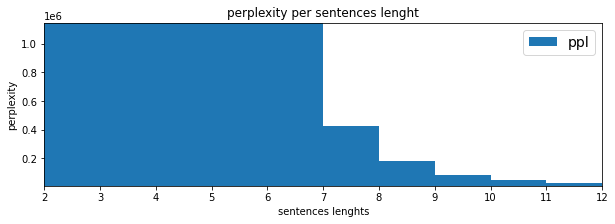

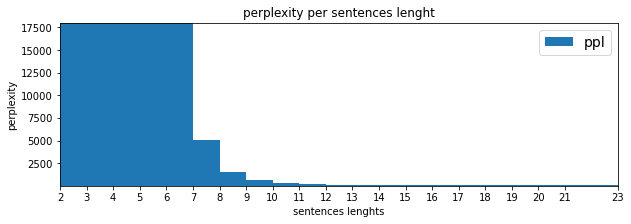

In [7]:
scores_per_lenghtp = {}
langsp = ["de-en.de", "en-fr.fr"]
# 174 482
for lang in langsp :
    scores_per_lenghtp[lang] = main(src_lang = lang, n_samples = 10000,  main_path = "/home/jupyter/data/fairseq/anki/")

[tensor(6840972.5000, device='cuda:0'), tensor(810109.8750, device='cuda:0'), tensor(608569.1250, device='cuda:0'), tensor(1078343.7500, device='cuda:0'), tensor(27060056., device='cuda:0'), tensor(525198.5625, device='cuda:0'), tensor(83570520., device='cuda:0'), tensor(18090638., device='cuda:0'), tensor(7.0035e+08, device='cuda:0'), tensor(3058816., device='cuda:0')]
=========================  en-jp.jp
tensor(5056182.)
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 30]
[827519552.0, 131542256.0, 50456440.0, 18388384.0, 9648748.0, 5279843.0, 3327585.75, 2351752.0, 1936155.25, 1481669.25, 1139877.125, 855671.6875, 731725.0625, 664480.1875, 626408.375, 494950.0, 583104.6875, 568286.3125, 867759.1875, 340438.5, 208639.90625, 154416.1875, 417483.125, 182981.234375, 187645.375]
[2, 30, 154416.1875, 827519552.0]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


AssertionError: 

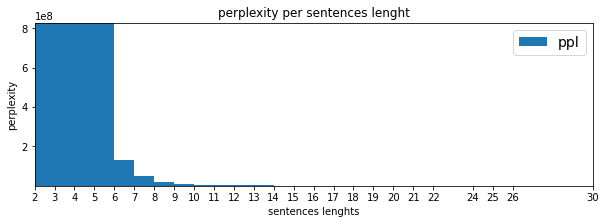

In [9]:
scores_per_lenghtpp = {}
langspp = ["en-jp.jp", "en-es.es, en-ro.ro"]
# 174 482
for lang in langspp :
    scores_per_lenghtpp[lang] = main(src_lang = lang, n_samples = 10000,  main_path = "/home/jupyter/data/fairseq/anki/")

[tensor(1871.7344, device='cuda:0'), tensor(610812.9375, device='cuda:0'), tensor(1686.8308, device='cuda:0'), tensor(867.1570, device='cuda:0'), tensor(2454.9824, device='cuda:0'), tensor(26420.6680, device='cuda:0'), tensor(4841.1387, device='cuda:0'), tensor(4475.9849, device='cuda:0'), tensor(5098.6436, device='cuda:0'), tensor(9857.6582, device='cuda:0')]
=========================  en-ro.ro
tensor(11512.5684)
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28]
[153955.484375, 1871.734375, 8125.89208984375, 25708.9765625, 27807.14453125, 20497.1328125, 12522.677734375, 10049.728515625, 12640.8251953125, 9078.509765625, 12802.9599609375, 8670.642578125, 7966.2373046875, 6982.39794921875, 7442.24755859375, 11790.02734375, 5586.33837890625, 3792.625, 4998.10693359375, 2511.121826171875, 6340.09619140625, 2647.177978515625, 12974.46875, 2538.40380859375, 1165.2010498046875]
[3, 28, 1165.2010498046875, 153955.484375]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


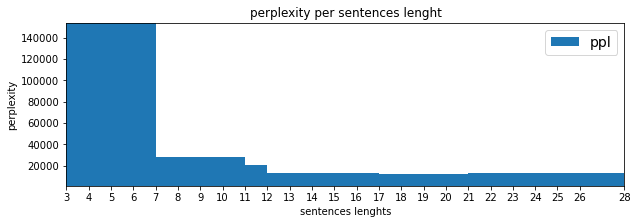

In [11]:
scores_per_lenghtpp = {}
langspp = ["en-ro.ro"]
# 174 482
for lang in langspp :
    scores_per_lenghtpp[lang] = main(src_lang = lang, n_samples = 10000,  main_path = "/home/jupyter/data/fairseq/anki/")

[tensor(658.3329, device='cuda:0'), tensor(3571.4365, device='cuda:0'), tensor(3128.6982, device='cuda:0'), tensor(9410.9541, device='cuda:0'), tensor(1235.9657, device='cuda:0'), tensor(1282.2512, device='cuda:0'), tensor(7344.8193, device='cuda:0'), tensor(2845.7156, device='cuda:0'), tensor(2257.4531, device='cuda:0'), tensor(2995.6919, device='cuda:0')]
=========================  en-es.es
tensor(4007.8872)
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[76550.6640625, 18014.732421875, 7968.78466796875, 3784.873046875, 2291.420166015625, 1449.2296142578125, 1044.2271728515625, 717.5789794921875, 621.7681274414062, 465.8775329589844, 317.9937438964844, 223.11874389648438, 201.86016845703125, 106.56097412109375, 190.1224365234375]
[3, 17, 106.56097412109375, 76550.6640625]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


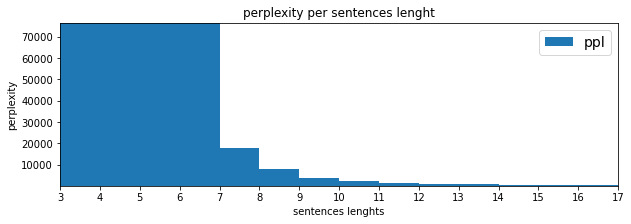

In [12]:
scores_per_lenghtpp = {}
langspp = ["en-es.es"]
# 174 482
for lang in langspp :
    scores_per_lenghtpp[lang] = main(src_lang = lang, n_samples = 10000,  main_path = "/home/jupyter/data/fairseq/anki/")

In [27]:
%cd /home/jupyter/fairseq

/home/jupyter/fairseq


# model

In [26]:
# download and extract the model
! wget -c https://dl.fbaipublicfiles.com/fairseq/models/lm/wmt19.en.tar.gz -P /home/jupyter/test
! tar -xvzf /home/jupyter/test/wmt19.en.tar.gz -C /home/jupyter/test

wmt19.en/
wmt19.en/model.pt
wmt19.en/dict.txt
wmt19.en/bpecodes


# data

In [29]:
%cd examples/language_model/
! bash prepare-wikitext-103.sh
%cd ../..

/home/jupyter/fairseq/examples/language_model
--2020-05-31 10:46:43--  https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.42.174
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.42.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190229076 (181M) [application/zip]
Saving to: ‘wikitext-103-v1.zip’

wikitext-103-v1.zip 100%[===================>] 181.42M  86.6MB/s    in 2.1s    

2020-05-31 10:46:45 (86.6 MB/s) - ‘wikitext-103-v1.zip’ saved [190229076/190229076]

https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip successfully downloaded.
Archive:  wikitext-103-v1.zip
   creating: wikitext-103/
  inflating: wikitext-103/wiki.test.tokens  
  inflating: wikitext-103/wiki.valid.tokens  
  inflating: wikitext-103/wiki.train.tokens  
/home/jupyter/fairseq


In [37]:
! pip install --editable .

Obtaining file:///home/jupyter/fairseq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 60 kB 2.5 MB/s eta 0:00:011
  Running setup.py develop for fairseq


In [51]:
%env modelpath=/home/jupyter/test/wmt19.en
%env destdir=data-bin/wikitext-103

env: modelpath=/home/jupyter/test/wmt19.en
env: destdir=data-bin/wikitext-103


In [52]:
%env TEXT=examples/language_model/wikitext-103
! fairseq-preprocess --only-source --trainpref $TEXT/wiki.train.tokens --validpref $TEXT/wiki.valid.tokens --testpref $TEXT/wiki.test.tokens --destdir $destdir --workers 20 --joined-dictionary --srcdict $modelpath/dict.txt

env: TEXT=examples/language_model/wikitext-103
2020-05-31 11:45:02 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, bf16=False, bpe=None, checkpoint_suffix='', cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='data-bin/wikitext-103', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=True, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=True, optimizer='nag', padding_factor=8, quantization_config_path=None, seed=1, source_lang=None, srcdict='/home/jupyter/test/wmt19.en/dict.txt', target_lang=None, task='translation', tensorboard_logdir='', testpref='examples/language_model/wikitext-103/wiki.test.tokens', tgtdict=None, threshold_loss_scale=No

In [53]:
! ls $destdir

dict.txt	test.bin  train.bin  valid.bin
preprocess.log	test.idx  train.idx  valid.idx


In [54]:
! fairseq-eval-lm data-bin/wikitext-103 --path $modelpath/model.pt --max-sentences 2 --tokens-per-sample 512 --context-window 400

2020-05-31 11:49:37 | INFO | fairseq_cli.eval_lm | Namespace(add_bos_token=False, all_gather_list_size=16384, bf16=False, bpe=None, broadcast_buffers=False, bucket_cap_mb=25, checkpoint_suffix='', context_window=400, cpu=False, criterion='cross_entropy', data='data-bin/wikitext-103', data_buffer_size=10, dataset_impl=None, ddp_backend='c10d', device_id=0, distributed_backend='nccl', distributed_init_method=None, distributed_no_spawn=False, distributed_port=-1, distributed_rank=0, distributed_world_size=1, distributed_wrapper='DDP', empty_cache_freq=0, fast_stat_sync=False, find_unused_parameters=False, fix_batches_to_gpus=False, force_anneal=None, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, future_target=False, gen_subset='test', localsgd_frequency=3, log_format=None, log_interval=100, lr_scheduler='fixed', lr_shrink=0.1, max_sentences=2, max_target_positions=None, max_tokens=None, memory_efficient_bf16=False, memory_e